In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
plt.style.use('seaborn')
%matplotlib inline

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

In [3]:
def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

# Calculate absorbance using first calibration of date

In this section I tried using the first calibration of a given date as the reference for examining the amount of etaloning that occurs.  The reference first calibration is used with each later calibration spectrum from that date.  The results are plotted by wavenumber.

I did this for three different dates.

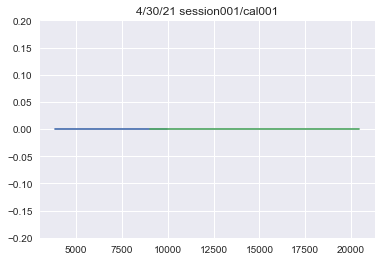

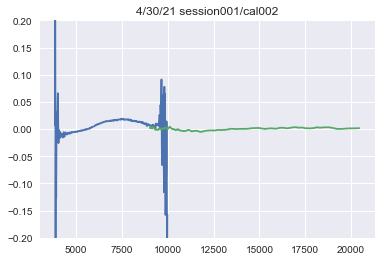

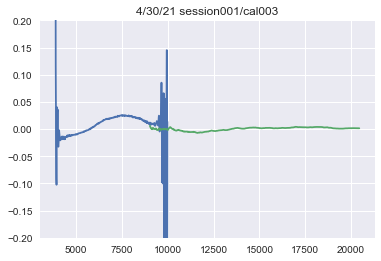

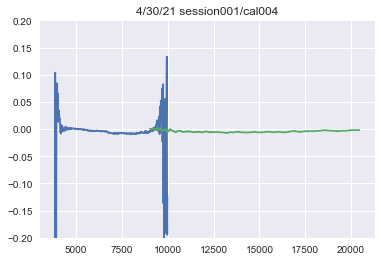

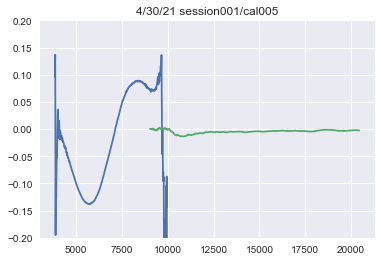

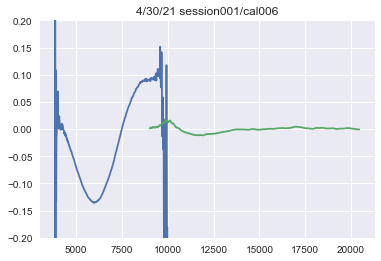

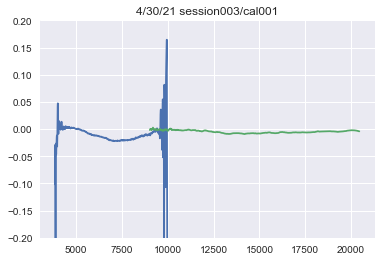

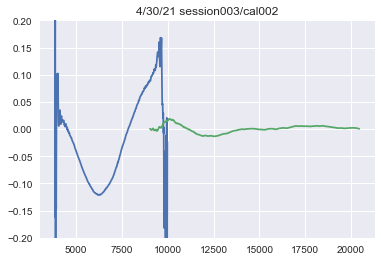

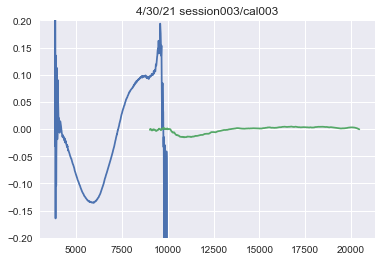

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/white_insertions_210503.csv')
date = '4/30/21'
session_df = df.loc[df['date'] == date].copy()
session_cals = session_df.groupby('c_unique').first()

for calibration in session_cals.index.values:    
    file_name = session_cals.loc[calibration, 'file_name']
    file = path_name + "/" + file_name
    cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']
    first_cal_path = session_cals.loc[session_cals.index.values[0], 'session'] + "/" + session_cals.loc[session_cals.index.values[0], 'calibration']
    first_ftir_spectrum = get_ftir_white_calibration_curve(file, first_cal_path)
    first_vis_spectrum = get_visible_white_calibration_curve(file, first_cal_path)
    
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
    ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
    ftir_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, first_ftir_spectrum, 0)
    
    
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    vis_wavelengths = get_visible_wavelength_vector(file, cal_path)
    vis_wavenums = calculate_wavenumbers_from_wavelengths(vis_wavelengths)
    vis_cal_abs = calculate_absorbance_from_raw(vis_cal_spectrum, first_vis_spectrum, 0)    
    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-0.2, 0.2)
    ax.set_title(f'{date} {cal_path}')
    
    ax.plot(ftir_wavenums, ftir_cal_abs)
    ax.plot(vis_wavenums, savgol_filter(vis_cal_abs, 21, 3))
    plt.show()
    plt.close()

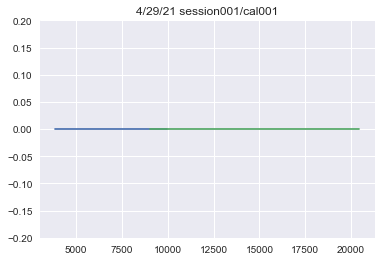

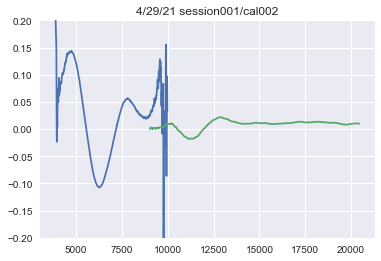

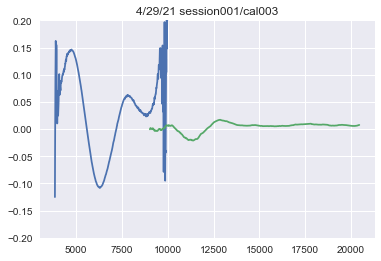

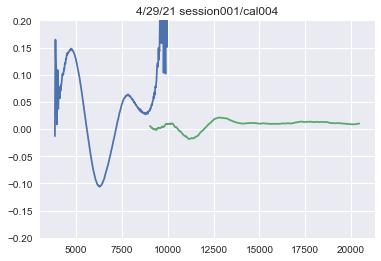

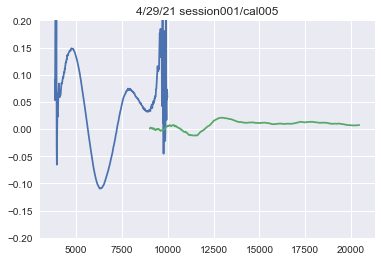

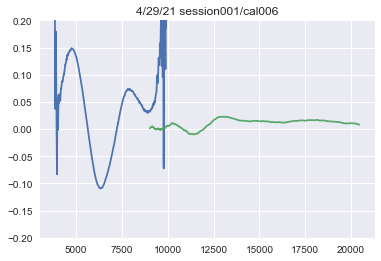

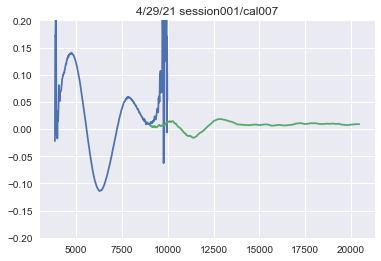

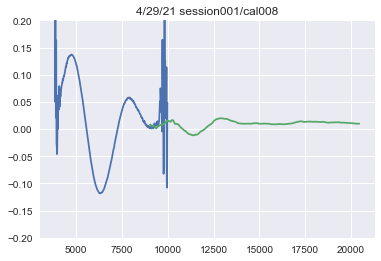

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/white_insertions_210503.csv')
date = '4/29/21'
session_df = df.loc[df['date'] == date].copy()
session_cals = session_df.groupby('c_unique').first()

for calibration in session_cals.index.values:    
    file_name = session_cals.loc[calibration, 'file_name']
    file = path_name + "/" + file_name
    cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']
    first_cal_path = session_cals.loc[session_cals.index.values[0], 'session'] + "/" + session_cals.loc[session_cals.index.values[0], 'calibration']
    first_ftir_spectrum = get_ftir_white_calibration_curve(file, first_cal_path)
    first_vis_spectrum = get_visible_white_calibration_curve(file, first_cal_path)
    
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
    ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
    ftir_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, first_ftir_spectrum, 0)
    
    
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    vis_wavelengths = get_visible_wavelength_vector(file, cal_path)
    vis_wavenums = calculate_wavenumbers_from_wavelengths(vis_wavelengths)
    vis_cal_abs = calculate_absorbance_from_raw(vis_cal_spectrum, first_vis_spectrum, 0)    
    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-0.2, 0.2)
    ax.set_title(f'{date} {cal_path}')
    
    ax.plot(ftir_wavenums, ftir_cal_abs)
    ax.plot(vis_wavenums, savgol_filter(vis_cal_abs, 21, 3))
    plt.show()
    plt.close()

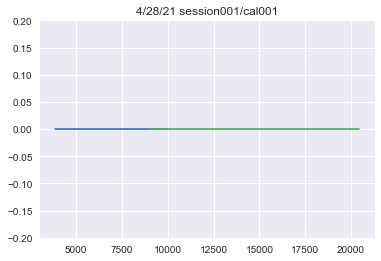

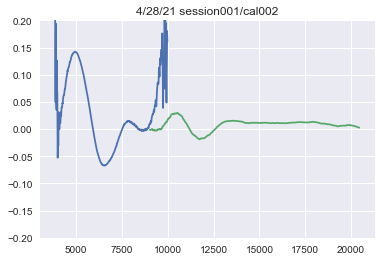

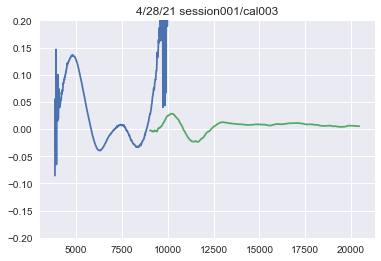

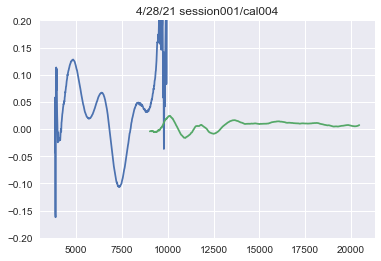

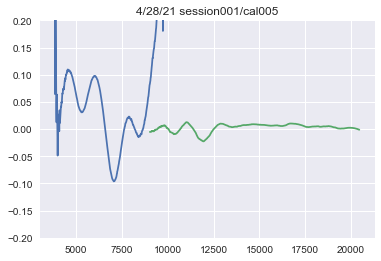

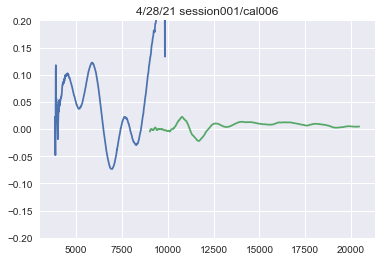

In [6]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/white_insertions_210503.csv')
date = '4/28/21'
session_df = df.loc[df['date'] == date].copy()
session_cals = session_df.groupby('c_unique').first()

for calibration in session_cals.index.values:    
    file_name = session_cals.loc[calibration, 'file_name']
    file = path_name + "/" + file_name
    cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']
    first_cal_path = session_cals.loc[session_cals.index.values[0], 'session'] + "/" + session_cals.loc[session_cals.index.values[0], 'calibration']
    first_ftir_spectrum = get_ftir_white_calibration_curve(file, first_cal_path)
    first_vis_spectrum = get_visible_white_calibration_curve(file, first_cal_path)
    
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
    ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
    ftir_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, first_ftir_spectrum, 0)
    
    
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    vis_wavelengths = get_visible_wavelength_vector(file, cal_path)
    vis_wavenums = calculate_wavenumbers_from_wavelengths(vis_wavelengths)
    vis_cal_abs = calculate_absorbance_from_raw(vis_cal_spectrum, first_vis_spectrum, 0)    
    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-0.2, 0.2)
    ax.set_title(f'{date} {cal_path}')
    
    ax.plot(ftir_wavenums, ftir_cal_abs)
    ax.plot(vis_wavenums, savgol_filter(vis_cal_abs, 21, 3))
    plt.show()
    plt.close()

# Calculate absorbance using previous calibration

In this section I decided that it would be more advantageous to use the previous calibration spectrum for calculating the absorbance for a given spectrum.  I also found the peak wavenumbers to see how evenly spaced the peaks were, and if they continued into the visible.

In [7]:
def plot_calibration_peaks(date):
    np.set_printoptions(precision=1)
    path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

    df = pd.read_csv('data/white_insertions_210503.csv')
    # date = '4/26/21'
    session_df = df.loc[df['date'] == date].copy()
    session_cals = session_df.groupby('c_unique').first()

    for calibration in session_cals.index.values:    
        file_name = session_cals.loc[calibration, 'file_name']
        file = path_name + "/" + file_name
        cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']

        cal_index = list(session_cals.index.values).index(calibration)
        if cal_index == 0:
            previous_cal = calibration
        else:
            previous_cal = session_cals.index.values[cal_index - 1]

        previous_cal_path = session_cals.loc[previous_cal, 'session'] + "/" + session_cals.loc[previous_cal, 'calibration']

        previous_ftir_spectrum = get_ftir_white_calibration_curve(file, previous_cal_path)
        previous_vis_spectrum = get_visible_white_calibration_curve(file, previous_cal_path)

        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
        ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
        ftir_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, previous_ftir_spectrum, 0)
        # ftir_abs_wavenum = put_spectrum_in_wavenum_order(ftir_cal_abs)

        ftir_up_peaks, _ = find_peaks(ftir_cal_abs, width = 50)
        ftir_down_peaks, _ = find_peaks(-ftir_cal_abs, width = 50)
        if ftir_up_peaks.size != 0:
            print(f'Up-peak wavenums: {np.flip(ftir_wavenums[ftir_up_peaks])}')
        if ftir_up_peaks.size >=2:
            diffs = np.diff(np.flip(ftir_wavenums[ftir_up_peaks]), n=1)
            print(f"Up-peak diffs {diffs}, mean: {diffs.mean():0.1f}")

        if ftir_down_peaks.size != 0:
            print(f'Down-peak wavenums: {np.flip(ftir_wavenums[ftir_down_peaks])}')
        if ftir_down_peaks.size >=2:
            diffs = np.diff(np.flip(ftir_wavenums[ftir_down_peaks]), n=1)
            print(f"Down-peak diffs {diffs}, mean: {diffs.mean():0.1f}")


        vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        vis_wavelengths = get_visible_wavelength_vector(file, cal_path)
        vis_wavenums = calculate_wavenumbers_from_wavelengths(vis_wavelengths)
        vis_cal_abs = calculate_absorbance_from_raw(vis_cal_spectrum, previous_vis_spectrum, 0)    
        # vis_abs_wavenum = put_spectrum_in_wavenum_order(vis_cal_abs)

        fig, ax = plt.subplots()
        ax.set_ylim(-0.2, 0.2)
        ax.set_title(f'{date} {cal_path}')

        ax.plot(ftir_wavenums, ftir_cal_abs)
        if ftir_up_peaks.size != 0:
            ax.plot(ftir_wavenums[ftir_up_peaks], ftir_cal_abs[ftir_up_peaks], 'ro')
        if ftir_down_peaks.size != 0:
            ax.plot(ftir_wavenums[ftir_down_peaks], ftir_cal_abs[ftir_down_peaks], 'bo')
        ax.plot(vis_wavenums, savgol_filter(vis_cal_abs, 21, 3))
        plt.show()
        plt.close()
    

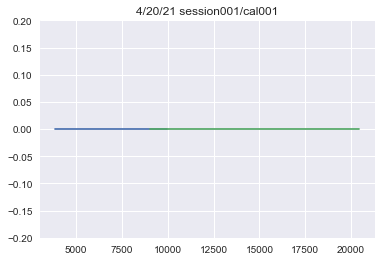

Up-peak wavenums: [7307.8]
Down-peak wavenums: [4941.1]


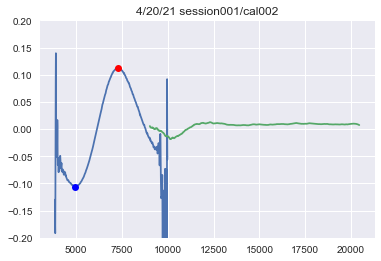

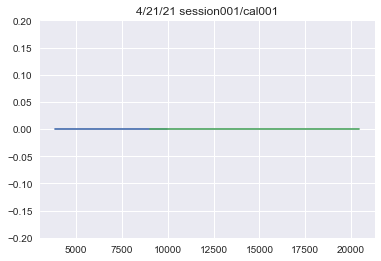

Up-peak wavenums: [9630.6]
Down-peak wavenums: [6071.9]


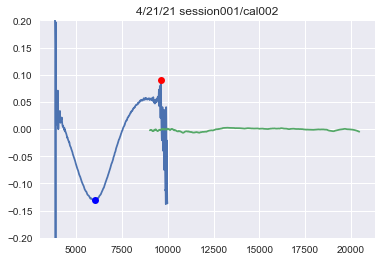

Up-peak wavenums: [5493.4]
Down-peak wavenums: [8035.3]


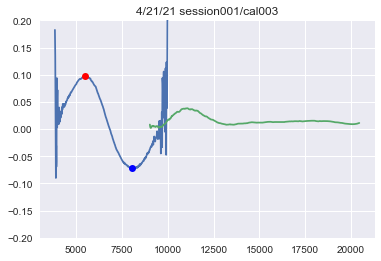

Up-peak wavenums: [7176.3]
Down-peak wavenums: [3968.2 9718.3]
Down-peak diffs [5750.1], mean: 5750.1


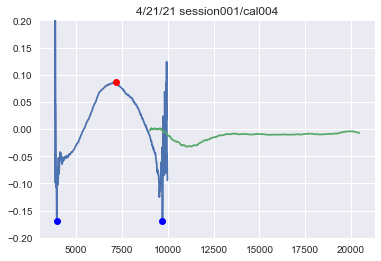

Up-peak wavenums: [9665.7]
Down-peak wavenums: [8140.5]


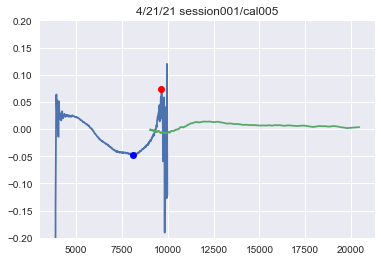

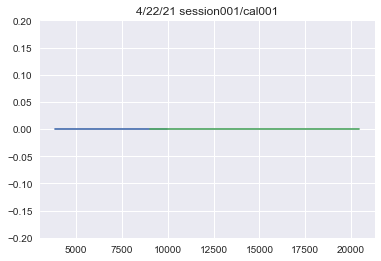

Up-peak wavenums: [9104.7]
Down-peak wavenums: [5826.4]


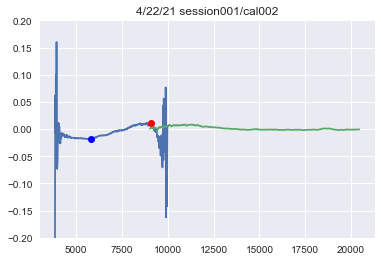

Up-peak wavenums: [4161.  4739.5]
Up-peak diffs [578.5], mean: 578.5


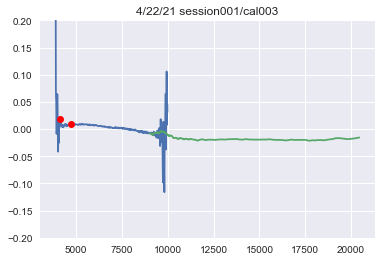

Up-peak wavenums: [4204.8 5396.9]
Up-peak diffs [1192.1], mean: 1192.1
Down-peak wavenums: [9104.7 9621.9]
Down-peak diffs [517.2], mean: 517.2


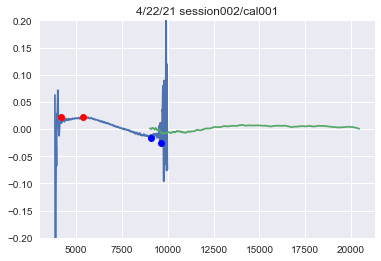

Up-peak wavenums: [4757.1]
Down-peak wavenums: [8482.4]


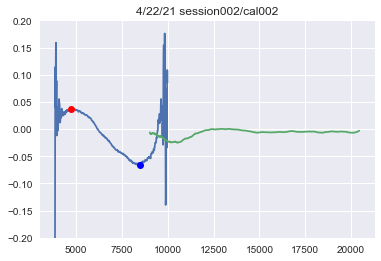

Up-peak wavenums: [4546.7]
Down-peak wavenums: [7246.4]


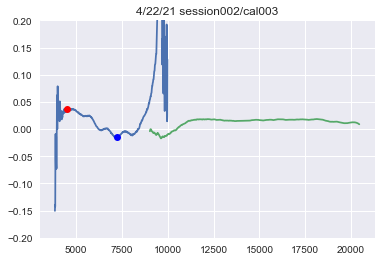

Up-peak wavenums: [4064.6 8324.6]
Up-peak diffs [4260.], mean: 4260.0
Down-peak wavenums: [6738.]


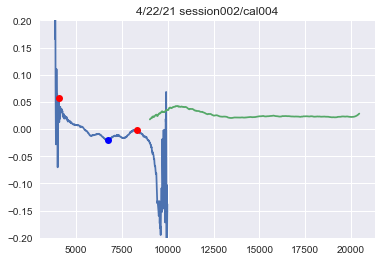

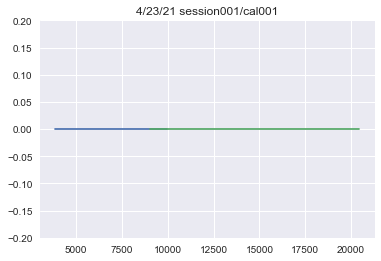

Down-peak wavenums: [7228.9]


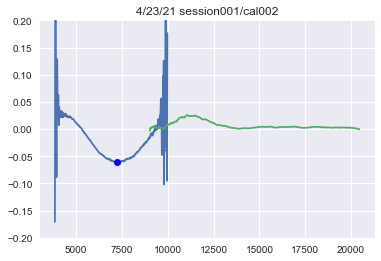

Up-peak wavenums: [4362.6 9648.2]
Up-peak diffs [5285.5], mean: 5285.5
Down-peak wavenums: [6229.7]


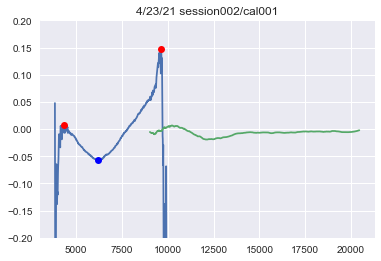

Up-peak wavenums: [4073.4 6720.5]
Up-peak diffs [2647.1], mean: 2647.1
Down-peak wavenums: [5283.  7965.2]
Down-peak diffs [2682.2], mean: 2682.2


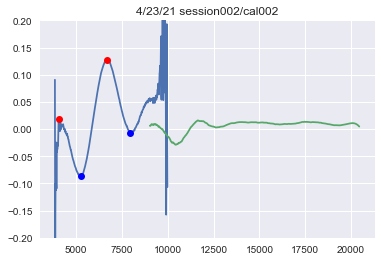

Up-peak wavenums: [5659.9 7991.5]
Up-peak diffs [2331.6], mean: 2331.6
Down-peak wavenums: [4529.2 6843.2 9148.5 9779.6]
Down-peak diffs [2314.1 2305.3  631.1], mean: 1750.2


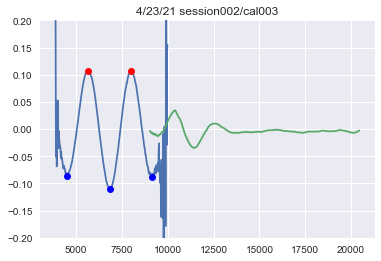

Up-peak wavenums: [5230.4 7281.5]
Up-peak diffs [2051.1], mean: 2051.1
Down-peak wavenums: [4082.1 6247.2 8324.6]
Down-peak diffs [2165.  2077.4], mean: 2121.2


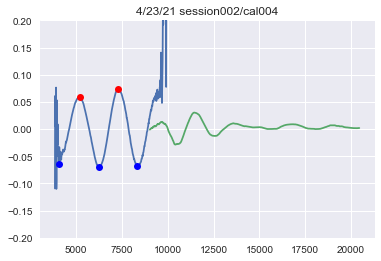

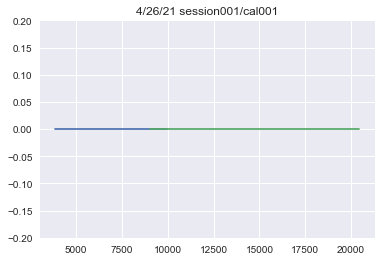

Up-peak wavenums: [3933.1]
Down-peak wavenums: [8017.8]


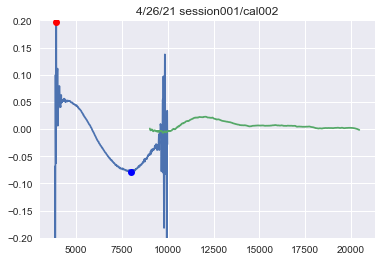

Up-peak wavenums: [9578.]
Down-peak wavenums: [3933.1 6352.4]
Down-peak diffs [2419.2], mean: 2419.2


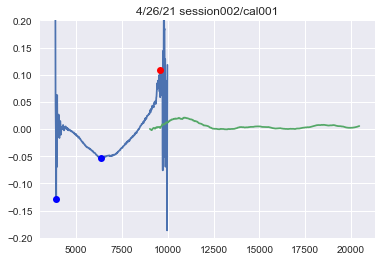

Up-peak wavenums: [6142.  8131.7]
Up-peak diffs [1989.7], mean: 1989.7
Down-peak wavenums: [4914.8 7106.2 9648.2]
Down-peak diffs [2191.3 2542. ], mean: 2366.7


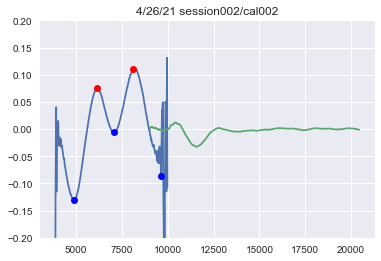

Up-peak wavenums: [5116.4 7228.9 9323.8]
Up-peak diffs [2112.5 2094.9], mean: 2103.7
Down-peak wavenums: [4047.1 6194.6 8236.9]
Down-peak diffs [2147.5 2042.3], mean: 2094.9


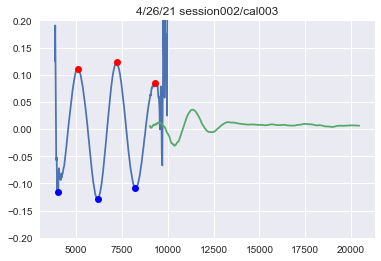

Up-peak wavenums: [4397.7 6212.1 7965.2]
Up-peak diffs [1814.4 1753.1], mean: 1783.8
Down-peak wavenums: [5335.6 7106.2 8859.3]
Down-peak diffs [1770.6 1753.1], mean: 1761.8


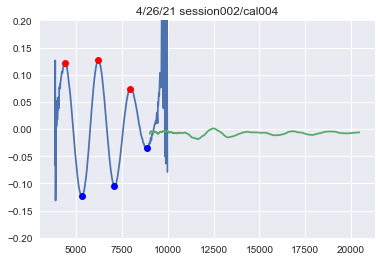

Up-peak wavenums: [5177.8 6913.4 8631.4]
Up-peak diffs [1735.5 1718. ], mean: 1726.8
Down-peak wavenums: [4239.9 6028.  7772.4]
Down-peak diffs [1788.1 1744.3], mean: 1766.2


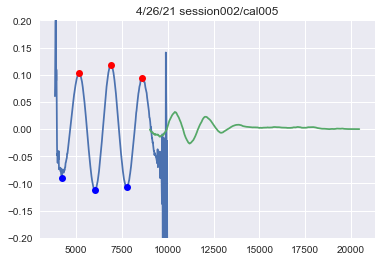

Up-peak wavenums: [3994.5 6019.3 7772.4]
Up-peak diffs [2024.8 1753.1], mean: 1888.9
Down-peak wavenums: [5177.8 6895.8 8596.3]
Down-peak diffs [1718.  1700.5], mean: 1709.2


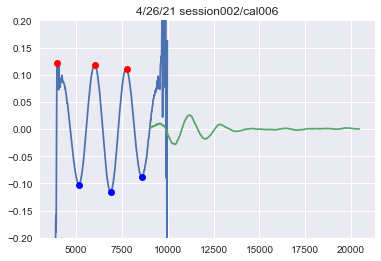

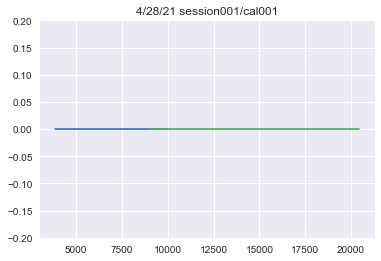

Up-peak wavenums: [4967.4 7895.1]
Up-peak diffs [2927.6], mean: 2927.6
Down-peak wavenums: [6554. 8719.]
Down-peak diffs [2165.], mean: 2165.0


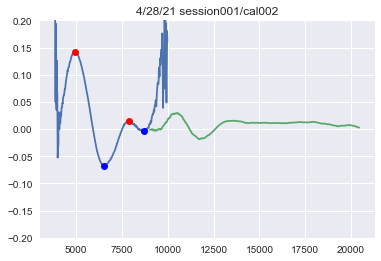

Up-peak wavenums: [6825.7 9727. ]
Up-peak diffs [2901.3], mean: 2901.3
Down-peak wavenums: [5475.8 8289.5]
Down-peak diffs [2813.7], mean: 2813.7


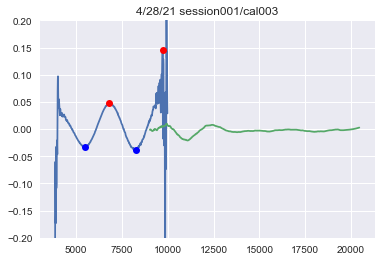

Up-peak wavenums: [4871.  6352.4 8403.5]
Up-peak diffs [1481.3 2051.1], mean: 1766.2
Down-peak wavenums: [4029.5 5370.6 7377.9]
Down-peak diffs [1341.1 2007.3], mean: 1674.2


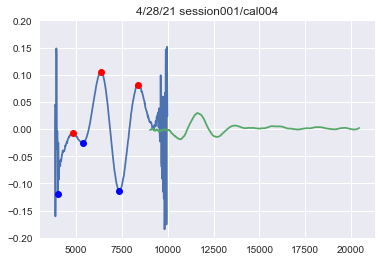

Up-peak wavenums: [4117.2 5922.9 7614.6]
Up-peak diffs [1805.7 1691.7], mean: 1748.7
Down-peak wavenums: [5072.6 6764.3 8421. ]
Down-peak diffs [1691.7 1656.7], mean: 1674.2


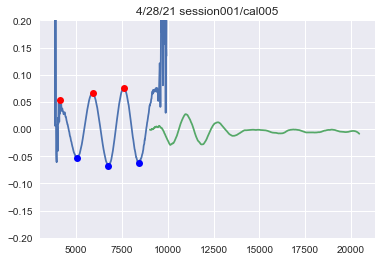

Up-peak wavenums: [5695.  7307.8 8982. ]
Up-peak diffs [1612.8 1674.2], mean: 1643.5
Down-peak wavenums: [4853.5 6518.9 8079.1]
Down-peak diffs [1665.4 1560.2], mean: 1612.8


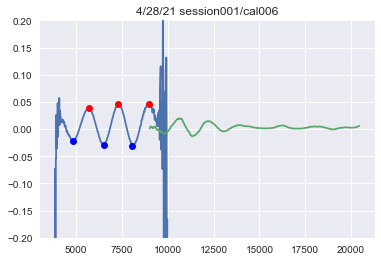

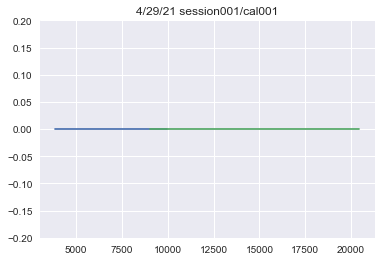

Up-peak wavenums: [4765.8 7842.5 9578. ]
Up-peak diffs [3076.6 1735.5], mean: 2406.1
Down-peak wavenums: [6299.8 8824.2]
Down-peak diffs [2524.4], mean: 2524.4


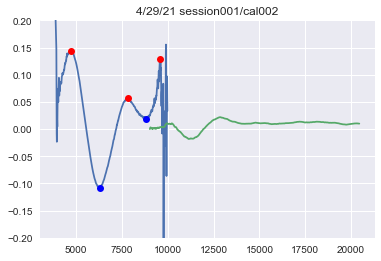

Up-peak wavenums: [5659.9 8149.3]
Up-peak diffs [2489.4], mean: 2489.4
Down-peak wavenums: [4117.2 6852. ]
Down-peak diffs [2734.8], mean: 2734.8


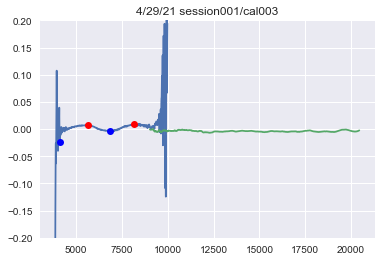

Up-peak wavenums: [6878.3]
Down-peak wavenums: [4099.7 5283.  8149.3]
Down-peak diffs [1183.3 2866.3], mean: 2024.8


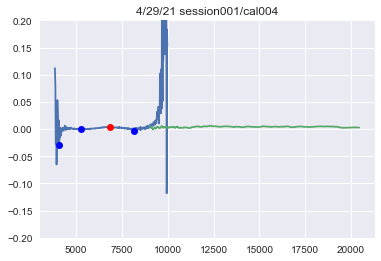

Up-peak wavenums: [4047.1 5519.7 8201.9]
Up-peak diffs [1472.6 2682.2], mean: 2077.4
Down-peak wavenums: [7001.]


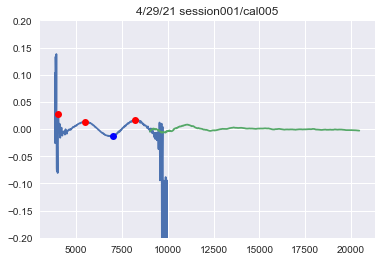

Up-peak wavenums: [4257.4]


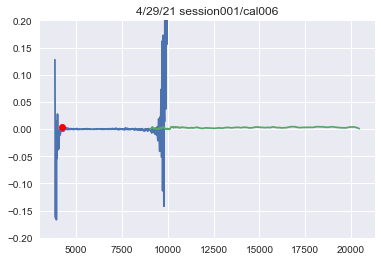

Up-peak wavenums: [4082.1 7036.1]
Up-peak diffs [2953.9], mean: 2953.9
Down-peak wavenums: [5607.3 9692. ]
Down-peak diffs [4084.7], mean: 4084.7


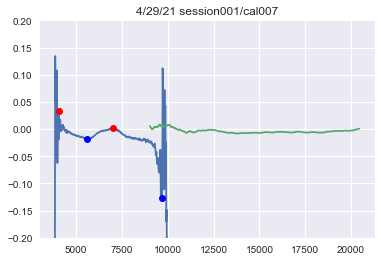

Up-peak wavenums: [4047.1 5405.7 8149.3]
Up-peak diffs [1358.6 2743.6], mean: 2051.1
Down-peak wavenums: [6729.3]


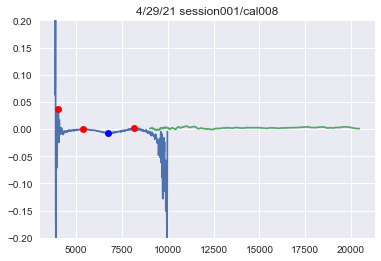

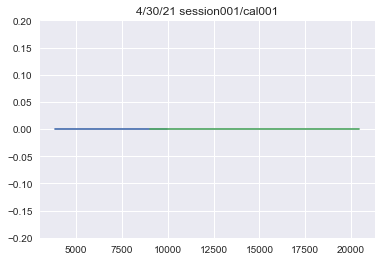

Up-peak wavenums: [7535.7 9665.7]
Up-peak diffs [2130.], mean: 2130.0
Down-peak wavenums: [4055.8 9341.4]
Down-peak diffs [5285.5], mean: 5285.5


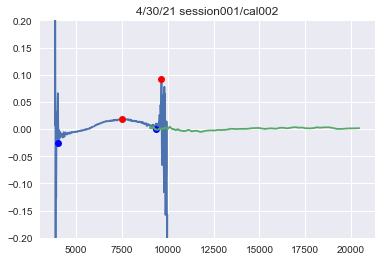

Up-peak wavenums: [7947.7 9516.7]
Up-peak diffs [1569.], mean: 1569.0


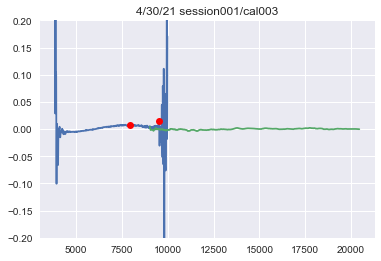

Down-peak wavenums: [7947.7 9665.7]
Down-peak diffs [1718.], mean: 1718.0


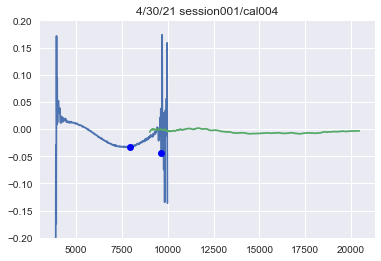

Up-peak wavenums: [4152.3 8324.6 9569.3]
Up-peak diffs [4172.3 1244.7], mean: 2708.5
Down-peak wavenums: [5686.2 9394. ]
Down-peak diffs [3707.8], mean: 3707.8


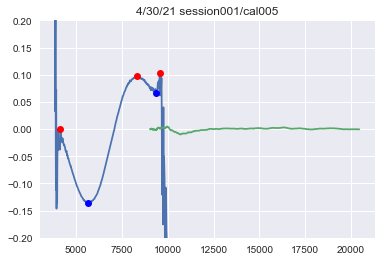

Up-peak wavenums: [4871.  9095.9]
Up-peak diffs [4224.9], mean: 4224.9
Down-peak wavenums: [7255.2]


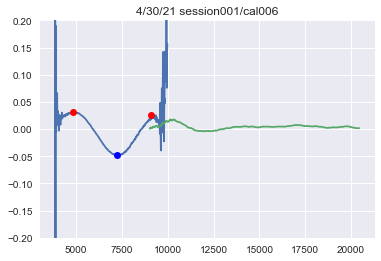

Up-peak wavenums: [6010.5]
Down-peak wavenums: [3985.7 8754.1 9595.6]
Down-peak diffs [4768.4  841.5], mean: 2804.9


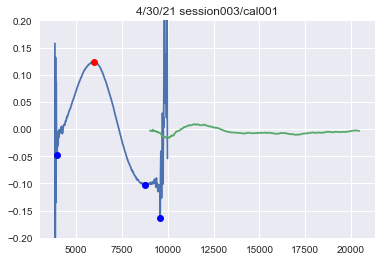

Up-peak wavenums: [9543.]
Down-peak wavenums: [6247.2]


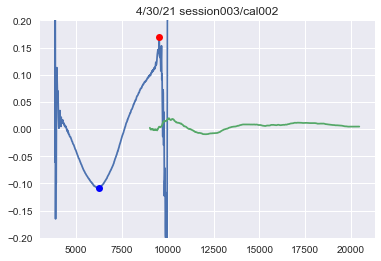

Up-peak wavenums: [7623.3]
Down-peak wavenums: [5134.  9271.2]
Down-peak diffs [4137.3], mean: 4137.3


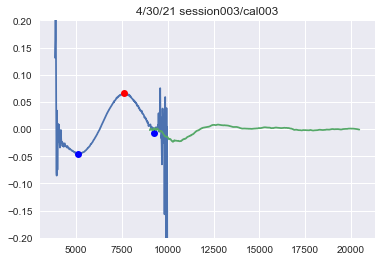

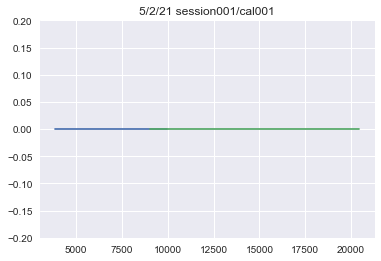

Up-peak wavenums: [5537.2 7605.8 9174.8]
Up-peak diffs [2068.6 1569. ], mean: 1818.8
Down-peak wavenums: [4336.3 6589.  8315.8]
Down-peak diffs [2252.7 1726.8], mean: 1989.7


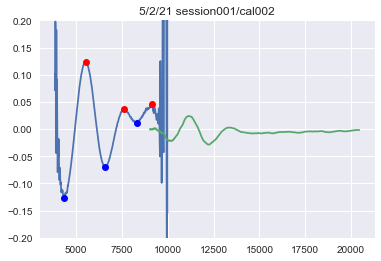

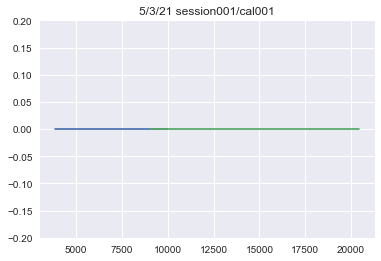

In [8]:
dates = df['date'].unique()

for date in dates:
    plot_calibration_peaks(date)

# FFT exploration

In this section I am exploring using fft and other types of filtering to see if I can design a method for removing the etaloning effects.  I ended up deciding that it would be very difficult and would likely be in danger of removing the signal as well as the etaloning.

In [9]:
from scipy.fft import fft, ifft, fftfreq

example_fft = fft(ftir_cal_abs)
example_power = np.abs(example_fft) ** 2

In [10]:
example_freq = fftfreq(example_fft.size)
example_freq

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0

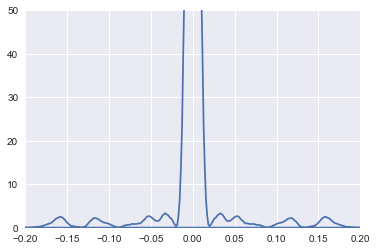

In [11]:
fig, ax = plt.subplots()
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(0, 50)
ax.plot(example_freq, example_power)

In [12]:
# filter out the low frequencies, then do the inverse transform
example_low_freq = example_fft.copy()
example_low_freq[np.abs(example_freq) < 0.2 ] = 0
filtered = ifft(example_low_freq)

/Users/linda/opt/miniconda3/envs/ds3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


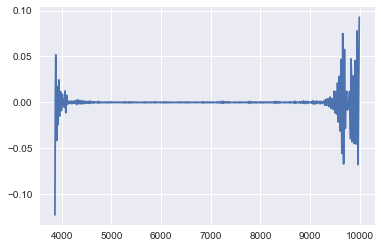

In [13]:
plt.plot(ftir_wavenums, filtered)

/Users/linda/opt/miniconda3/envs/ds3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


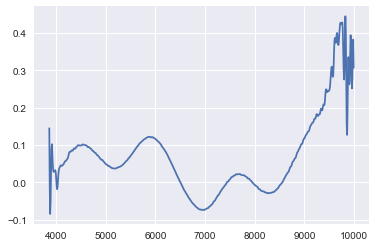

In [14]:
# presumably this is what was removed with the filter.
blah = ftir_cal_abs - filtered
plt.plot(ftir_wavenums, blah)

## Other filtering mechanisms

In [16]:
from scipy.signal import freqz
from scipy.signal import butter, lfilter

In [18]:
# got this from the internet

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

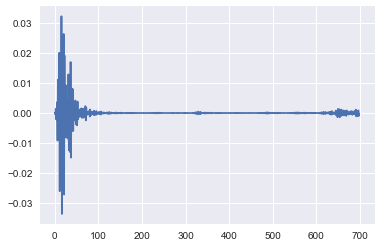

In [19]:
# trying it out with my data
fs = 700.0
lowcut = 250.0
highcut = 310.0

y = butter_bandpass_filter(ftir_cal_abs, lowcut, highcut, fs, order=6)

plt.plot(y)

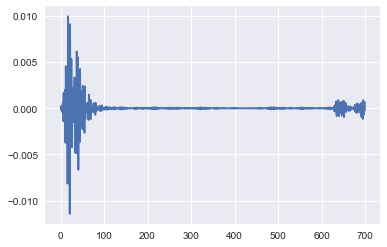

In [20]:
# another try with another spectrum

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/white_insertions_210503.csv')
date = '4/22/21'
session_df = df.loc[df['date'] == date].copy()
session_cals = session_df.groupby('c_unique').first()
calibration = 'c012'
previous_cal = 'c011'
file_name = session_cals.loc[calibration, 'file_name']
file = path_name + "/" + file_name
cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']
previous_cal_path = session_cals.loc[previous_cal, 'session'] + "/" + session_cals.loc[previous_cal, 'calibration']
previous_ftir_spectrum = get_ftir_white_calibration_curve(file, previous_cal_path)
ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
ftir_cal_abs2 = calculate_absorbance_from_raw(ftir_cal_spectrum, previous_ftir_spectrum, 0)

fs = 700.0
lowcut = 250.0
highcut = 310.0

y2 = butter_bandpass_filter(ftir_cal_abs2, lowcut, highcut, fs, order=6)

plt.plot(y2)

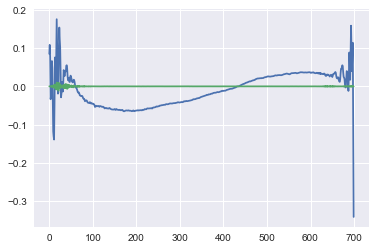

In [22]:
# the original and the filtered
plt.plot(ftir_cal_abs2)
plt.plot(y2)

# Green milk jug cap and soil sample data

I decided to look at some of the green milk jug cap spectra and soil sample data.

In [23]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = "210422_green_tests/green_testing_210422.h5"
file = path_name + "/" + file_name
green_insertion_path = 'session002/cal002/ins018'
soil_insertion_path = 'session002/cal002/ins017'

green_cap_raws = get_ftir_insertion_raw_spectra(file, green_insertion_path)
soil_raws = get_ftir_insertion_raw_spectra(file, soil_insertion_path)

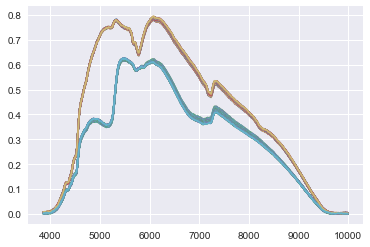

In [25]:
# the raw spectra plotted by wavenumbers for the green cap and the soil sample
fig, ax = plt.subplots()
for i in range(green_cap_raws.shape[0]):
    ax.plot(ftir_wavenums, green_cap_raws[i, :])
    ax.plot(ftir_wavenums, soil_raws[i, :])

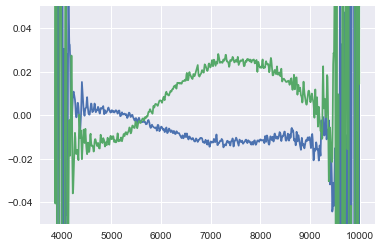

In [26]:
# here I use the absorbance function to ratio the last raw green cap spectrum with the first green cap raw spectrum
# same for the soil sample

green_try_abs = calculate_absorbance_from_raw(green_cap_raws[-1, :], green_cap_raws[0, :], 0)
soil_try_abs = calculate_absorbance_from_raw(soil_raws[-1, :], soil_raws[0, :], 0)

fig, ax = plt.subplots()
ax.set_ylim(-0.05, 0.05)
ax.plot(ftir_wavenums, green_try_abs)
ax.plot(ftir_wavenums, soil_try_abs)
plt.show()
plt.close()

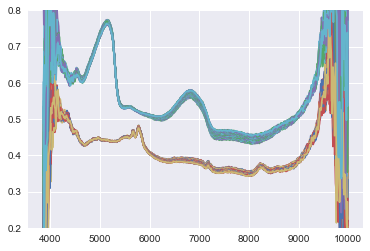

In [28]:
# The stored absorbances for both green cap and soil sample
# plot by wavenumber

green_absorbances = get_ftir_insertion_absorbances(file, green_insertion_path)
soil_absorbances = get_ftir_insertion_absorbances(file, soil_insertion_path)

fig, ax = plt.subplots()
ax.set_ylim(0.2, 0.8)
for i in range(green_cap_raws.shape[0]):
    ax.plot(ftir_wavenums, green_absorbances[i, :])
    ax.plot(ftir_wavenums, soil_absorbances[i, :])
plt.show()
plt.close()

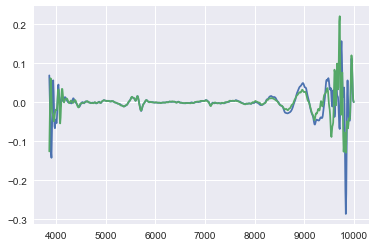

In [32]:
# tried the band pass filter from above on the green cap spectrum
# plotting the first and last green cap spectrum filtered
# in practice I tried many different settings for the low and high cut.

fs = 700.0
lowcut = 10.0
highcut = 120.0

green_filter1 = butter_bandpass_filter(green_absorbances[0, :], lowcut, highcut, fs, order=6)
green_filter2 = butter_bandpass_filter(green_absorbances[-1, :], lowcut, highcut, fs, order=6)

fig, ax = plt.subplots()
# ax.set_ylim(-0.05, 0.05)
ax.plot(ftir_wavenums, green_filter1)
ax.plot(ftir_wavenums, green_filter2)
plt.show()
plt.close()

### Can you subtract out the signal using the "absorbance" ratio calculated from the first and last spectrum of the series?

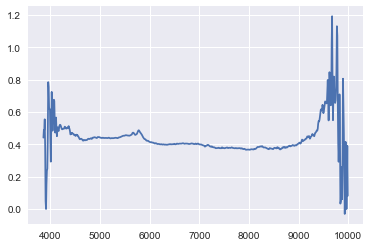

In [31]:
# This is the first green cap spectrum with the "absorbance" subtracted out, plotted by wavenumber.
plt.plot(ftir_wavenums, green_absorbances[0, :] - green_try_abs)

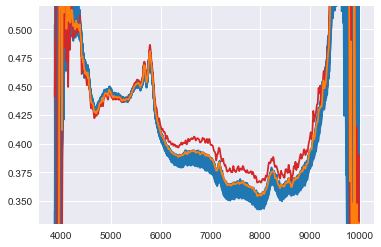

In [37]:
# The first and last green cap spectcra with the "absorbance" subtracted out, shown in orange and red
# Blue specctra are the original stored absorbance spectra.
subtracted1 = green_absorbances[0, :] - green_try_abs
subtracted2 = green_absorbances[-1, :] - green_try_abs

fig, ax = plt.subplots()
ax.set_ylim(0.33, 0.52)
for i in range(green_cap_raws.shape[0]):
    ax.plot(ftir_wavenums, green_absorbances[i, :], "tab:blue")
ax.plot(ftir_wavenums, subtracted1, "tab:red")
ax.plot(ftir_wavenums, subtracted2, "tab:orange")
plt.show()
plt.close()

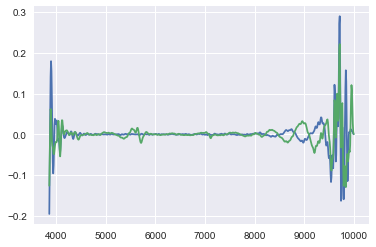

In [39]:
# trying the filter with the green cap spectra some more
fs = 700.0
lowcut = 10.0
highcut = 120.0

green_try_abs_filt = butter_bandpass_filter(green_try_abs, lowcut, highcut, fs, order=6)

fig, ax = plt.subplots()
# ax.set_ylim(-0.05, 0.05)
ax.plot(ftir_wavenums, green_try_abs_filt)
ax.plot(ftir_wavenums, green_filter2)
plt.show()
plt.close()

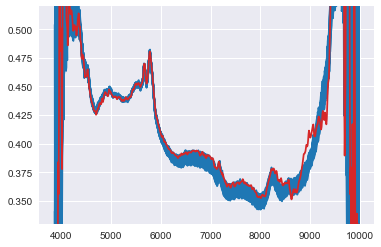

In [41]:
green_subtract = green_absorbances[0, :] - green_try_abs_filt

fig, ax = plt.subplots()
ax.set_ylim(0.33, 0.52)
for i in range(green_cap_raws.shape[0]):
    ax.plot(ftir_wavenums, green_absorbances[i, :], "tab:blue")
ax.plot(ftir_wavenums, green_subtract, "tab:red")

plt.show()
plt.close()

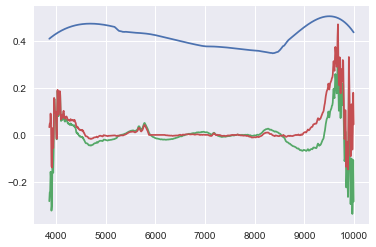

In [43]:
# trying a median filter alongside the bandpass filter
from scipy.signal import medfilt
green1 = green_absorbances[0, :]
green_raw1 = green_cap_raws[0, :]
soil1 = soil_absorbances[0, :]

fs = 700.0
lowcut = 10.0
highcut = 120.0

green_butter = butter_bandpass_filter(green1, lowcut, highcut, fs, order=6)
green_med = medfilt(green1, 201)

plt.plot(ftir_wavenums, savgol_filter(green1, 301, 3))
plt.plot(ftir_wavenums, green1 - savgol_filter(green1, 301, 3))
# plt.plot(ftir_wavenums, green_butter)
plt.plot(ftir_wavenums, green1 - green_med)

In [46]:
# seeing what happens if youcalculate using the previous calibration

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = "210422_green_tests/green_testing_210422.h5"
file = path_name + "/" + file_name
green_cal_path = 'session002/cal002'
green_previous_cal = 'session002/cal001'

previous_ftir_spectrum = get_ftir_white_calibration_curve(file, green_previous_cal)
ftir_cal_spectrum = get_ftir_white_calibration_curve(file, green_cal_path)
ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
green_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, previous_ftir_spectrum, 0)


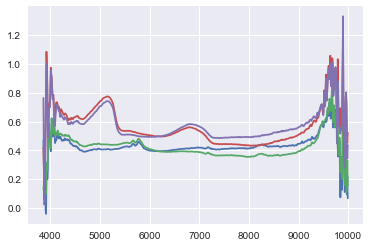

In [47]:
# plt.plot(ftir_wavenums, savgol_filter(green1, 301, 3))
# plt.plot(ftir_wavenums, green1 - savgol_filter(green1, 301, 3))
# plt.plot(ftir_wavenums, green_butter)
# plt.plot(ftir_wavenums, green1 - green_med)
plt.plot(ftir_wavenums, green1 - green_cal_abs)
plt.plot(ftir_wavenums, green1)
plt.plot(ftir_wavenums, soil1)
plt.plot(ftir_wavenums, soil1 - green_cal_abs)

# Looking at older data containing different target spectra, not just white blank spectra

Using the same method from above, looking at subsequent calibration spectraf

In [51]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/Green_misc_insertions.csv')

dates = df['date'].unique()


def plot_misc_calibration_peaks(date):
    np.set_printoptions(precision=1)
    path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

    df = pd.read_csv('data/Green_misc_insertions.csv')
    # date = '4/26/21'
    session_df = df.loc[df['date'] == date].copy()
    session_cals = session_df.groupby('c_unique').first()

    for calibration in session_cals.index.values:    
        file_name = session_cals.loc[calibration, 'file_name']
        file = path_name + file_name
        print(file)
        cal_path = session_cals.loc[calibration, 'session'] + "/" + session_cals.loc[calibration, 'calibration']

        cal_index = list(session_cals.index.values).index(calibration)
        print(cal_index)
        if cal_index == 0:
            previous_cal = calibration
            previous_cal_path = cal_path
            previous_file = file
        else:
            previous_cal = session_cals.index.values[cal_index - 1]
            previous_cal_path = session_cals.loc[previous_cal, 'session'] + "/" + session_cals.loc[previous_cal, 'calibration']
            previous_file_name = session_cals.loc[previous_cal, 'file_name']
            previous_file = path_name + previous_file_name
        print(previous_cal_path)

        previous_vis_spectrum = get_visible_white_calibration_curve(previous_file, previous_cal_path)
        previous_ftir_spectrum = get_ftir_white_calibration_curve(previous_file, previous_cal_path)
        

        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ftir_wavelengths = get_ftir_wavelength_vector(file, cal_path)
        ftir_wavenums = calculate_wavenumbers_from_wavelengths(ftir_wavelengths)
        ftir_cal_abs = calculate_absorbance_from_raw(ftir_cal_spectrum, previous_ftir_spectrum, 0)
        # ftir_abs_wavenum = put_spectrum_in_wavenum_order(ftir_cal_abs)

        ftir_up_peaks, _ = find_peaks(ftir_cal_abs, width = 50)
        ftir_down_peaks, _ = find_peaks(-ftir_cal_abs, width = 50)
        if ftir_up_peaks.size != 0:
            print(f'Up-peak wavenums: {np.flip(ftir_wavenums[ftir_up_peaks])}')
        if ftir_up_peaks.size >=2:
            diffs = np.diff(np.flip(ftir_wavenums[ftir_up_peaks]), n=1)
            print(f"Up-peak diffs {diffs}, mean: {diffs.mean():0.1f}")

        if ftir_down_peaks.size != 0:
            print(f'Down-peak wavenums: {np.flip(ftir_wavenums[ftir_down_peaks])}')
        if ftir_down_peaks.size >=2:
            diffs = np.diff(np.flip(ftir_wavenums[ftir_down_peaks]), n=1)
            print(f"Down-peak diffs {diffs}, mean: {diffs.mean():0.1f}")


        vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        vis_wavelengths = get_visible_wavelength_vector(file, cal_path)
        vis_wavenums = calculate_wavenumbers_from_wavelengths(vis_wavelengths)
        vis_cal_abs = calculate_absorbance_from_raw(vis_cal_spectrum, previous_vis_spectrum, 0)    
        # vis_abs_wavenum = put_spectrum_in_wavenum_order(vis_cal_abs)

        fig, ax = plt.subplots()
        ax.set_ylim(-0.2, 0.2)
        ax.set_title(f'{date} {cal_path}')

        ax.plot(ftir_wavenums, ftir_cal_abs)
        if ftir_up_peaks.size != 0:
            ax.plot(ftir_wavenums[ftir_up_peaks], ftir_cal_abs[ftir_up_peaks], 'ro')
        if ftir_down_peaks.size != 0:
            ax.plot(ftir_wavenums[ftir_down_peaks], ftir_cal_abs[ftir_down_peaks], 'bo')
        ax.plot(vis_wavenums, savgol_filter(vis_cal_abs, 21, 3))
        plt.show()
        plt.close()
        
        

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210330_spectrometer_tests/spect_test3.h5
0
session001/cal001


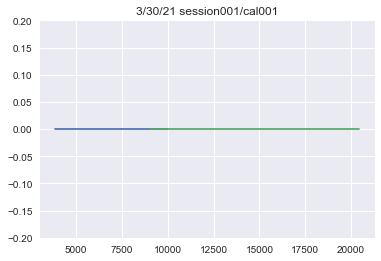

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210330_spectrometer_tests/spect_test5.h5
1
session001/cal001
Up-peak wavenums: [3898.1 8324.6]
Up-peak diffs [4426.5], mean: 4426.5
Down-peak wavenums: [4397.7 4581.8]
Down-peak diffs [184.1], mean: 184.1


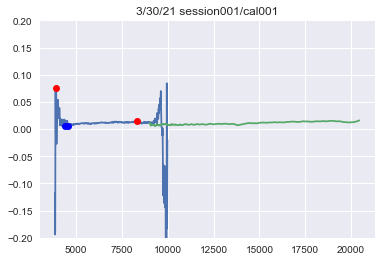

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210330_spectrometer_tests/spect_test6.h5
2
session001/cal001
Up-peak wavenums: [4134.7 8815.4]
Up-peak diffs [4680.7], mean: 4680.7
Down-peak wavenums: [5353.1]


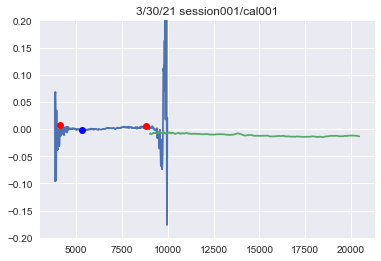

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210401_tests/vis_ftir_test1.h5
0
session001/cal002


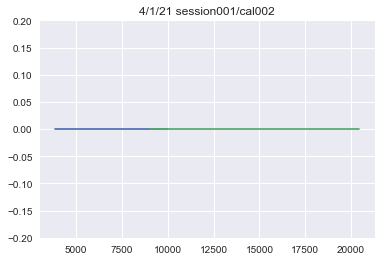

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210402_SOC_canister/tests_210402.h5
0
session002/cal001


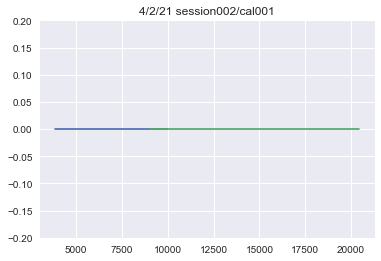

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210409_stationary_moving/blank_210409.h5
0
session003/cal001


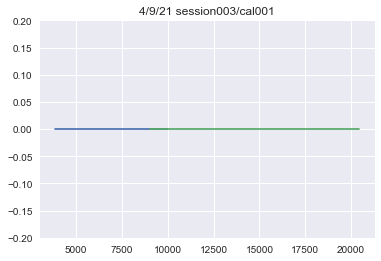

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210409_stationary_moving/blank_210409.h5
1
session003/cal001
Up-peak wavenums: [7737.3]
Down-peak wavenums: [5659.9 9656.9]
Down-peak diffs [3997.], mean: 3997.0


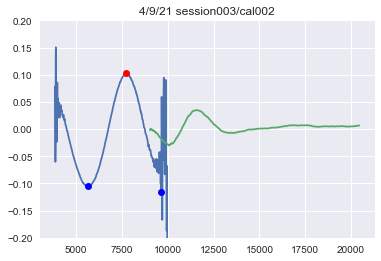

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419.h5
0
session001/cal002


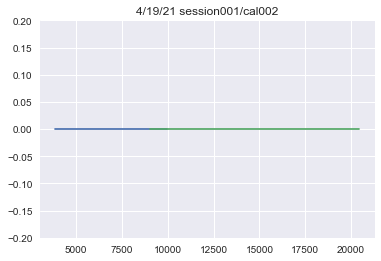

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419b.h5
1
session001/cal002
Up-peak wavenums: [5852.7]
Down-peak wavenums: [3985.7 8876.8]
Down-peak diffs [4891.1], mean: 4891.1


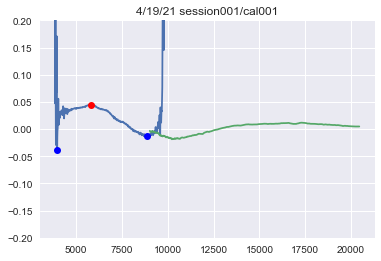

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419b.h5
2
session001/cal001
Up-peak wavenums: [3915.6]
Down-peak wavenums: [7982.7]


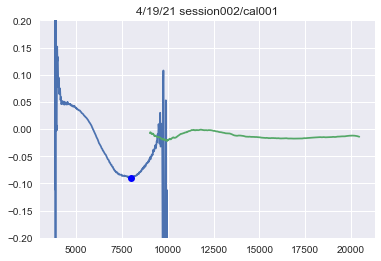

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419b.h5
3
session002/cal001
Up-peak wavenums: [8052.9]
Down-peak wavenums: [5440.8]


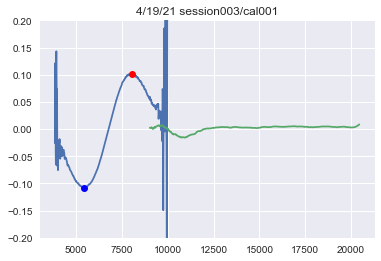

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419c.h5
4
session003/cal001
Up-peak wavenums: [6571.5]
Down-peak wavenums: [4082.1 4476.6 8666.4]
Down-peak diffs [ 394.4 4189.9], mean: 2292.1


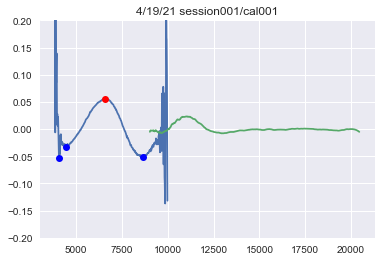

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419c.h5
5
session001/cal001
Up-peak wavenums: [5265.5 8911.9 9744.6]
Up-peak diffs [3646.4  832.7], mean: 2239.6
Down-peak wavenums: [7167.5]


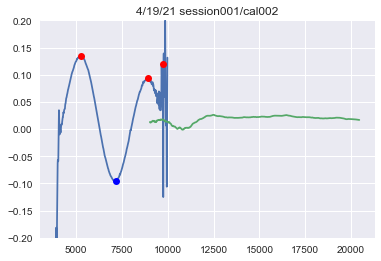

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210419_green_tests/green_testing_210419c.h5
6
session001/cal002
Up-peak wavenums: [5528.4 7342.9]
Up-peak diffs [1814.4], mean: 1814.4
Down-peak wavenums: [3941.9 4537.9 6212.1 8473.6]
Down-peak diffs [ 596.  1674.2 2261.5], mean: 1510.6


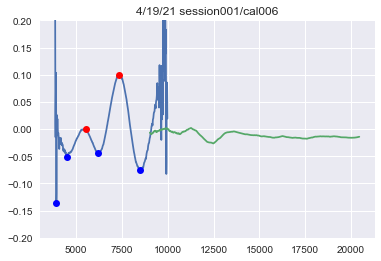

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210420_green_tests/green_testing_210420.h5
0
session001/cal001


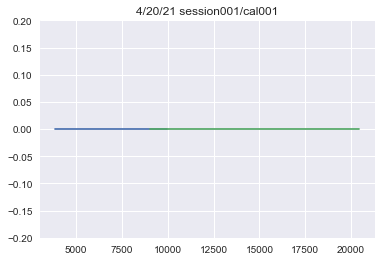

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210420_green_tests/green_testing_210420.h5
1
session001/cal001
Up-peak wavenums: [4529.2]
Down-peak wavenums: [6615.3]


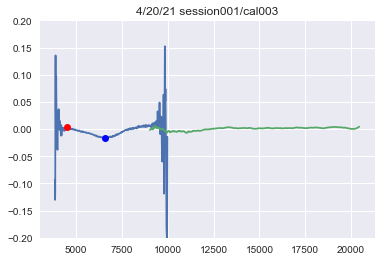

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210420_green_tests/green_testing_210420.h5
2
session001/cal003
Up-peak wavenums: [5283.  9306.3]
Up-peak diffs [4023.3], mean: 4023.3
Down-peak wavenums: [7675.9]


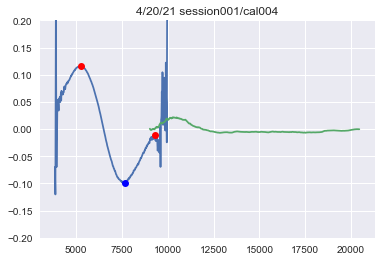

In [52]:
for date in dates:
    plot_misc_calibration_peaks(date)

# Soil spectra from 4/1/21

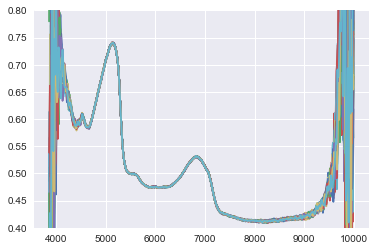

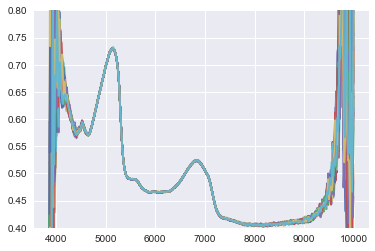

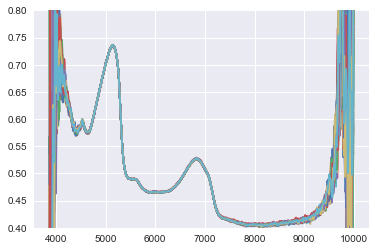

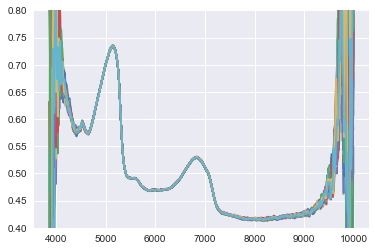

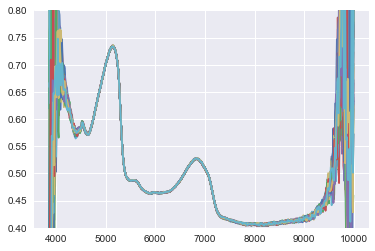

In [55]:
file_name = '210401_tests/vis_ftir_test1.h5'
file = path_name + file_name
cal_path = 'session001/cal002'
insertions = ['ins011', 'ins012', 'ins013', 'ins014', 'ins015']
for insertion in insertions:
    insertion_path = cal_path + '/' + insertion
    fig, ax = plt.subplots()
    ax.set_ylim(0.4, 0.8)
    ins_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
    for i in range(ins_absorbances.shape[0]):
        ax.plot(ftir_wavenums, ins_absorbances[i, :])
    plt.show()
    plt.close()

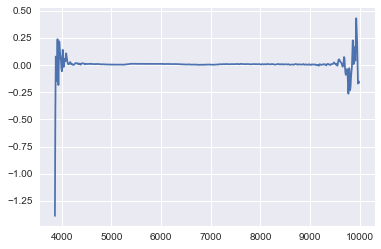

In [62]:
# getting the first and last absorbance spectra from the soil spectra series
# these are the moist soil spectra

first_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins011')[0, :]
last_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins015')[0, :]


# Use the first and last absorbance spectra in the series to calculate an "absorbance" ratio
# Note that the first and last spectra from this date are very much the same (flat spectrum)

relative_absorbance = calculate_absorbance_from_raw(last_absorbance, first_absorbance, 0)

plt.plot(ftir_wavenums, relative_absorbance);

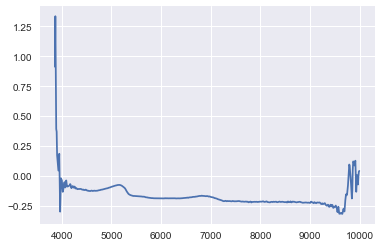

In [63]:
# Same method, but this time using the dry soil spectra series
# There are more differences, but I tend to think this is not etaloning here

first_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins001')[0, :]
last_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins005')[-1, :]
relative_absorbance = calculate_absorbance_from_raw(last_absorbance, first_absorbance, 0)
plt.plot(ftir_wavenums, relative_absorbance);


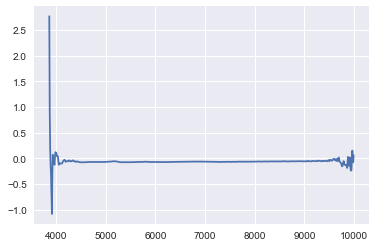

In [64]:
# Same method, but this time using the spiked soil spectra series

first_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins021')[0, :]
last_absorbance = get_ftir_insertion_absorbances(file, 'session001/cal002/ins025')[-1, :]
relative_absorbance = calculate_absorbance_from_raw(last_absorbance, first_absorbance, 0)
plt.plot(ftir_wavenums, relative_absorbance)

In [ ]:
file_name = '210413_BNP_transect/BNP_data_collection_210413.h5'
file = path_name + file_name
cal_path = 'session001/cal001'
insertion_path = 'session001/cal001/ins003'

In [ ]:
ins_absorbances = get_ftir_insertion_absorbances(file, insertion_path)
for insertion in ins_absorbances